# CYBERBULLYING CLASSIFICATION - EQUIPO 4


## DATASET

[Dataset: Cyberbullying Classification](https://www.kaggle.com/datasets/andrewmvd/cyberbullying-classification/data)

## IMPORTS

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import re
import nltk
import spacy
from nltk.corpus import stopwords
from wordcloud import WordCloud
from collections import Counter
from nltk.tokenize import word_tokenize
import plotly.express as px
from textblob import TextBlob

import tensorflow as tf
import os
import torch
from torch.utils.data import Dataset
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments,EarlyStoppingCallback
from transformers import AutoTokenizer, AutoModelForSequenceClassification

from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay,classification_report
from sklearn.metrics import f1_score, precision_score, recall_score, roc_curve, auc, roc_auc_score
from sklearn.model_selection import GridSearchCV, cross_val_score, RandomizedSearchCV
from sklearn.datasets import make_classification
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, SpatialDropout1D, Conv1D, MaxPooling1D, Dropout , Bidirectional
from tensorflow.keras.initializers import Constant
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

#import xgboost as xgb

## INTRODUCCIÓN

In [3]:
url = "https://raw.githubusercontent.com/noequalindi/1000IA_course/main/cyberbullying_tweets.csv"
df_raw = pd.read_csv(url, sep=',')
df_raw.head()

,tweet_text,cyberbullying_type
0,"In other words #katandandre, your food was cra...",not_cyberbullying
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying


In [4]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47692 entries, 0 to 47691
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_text          47692 non-null  object
 1   cyberbullying_type  47692 non-null  object
dtypes: object(2)
memory usage: 745.3+ KB


In [5]:
df_raw.describe()

,tweet_text,cyberbullying_type
count,47692,47692
unique,46017,6
top,RT @sailorhg: the intro for my hardware hackin...,religion
freq,2,7998


In [6]:
categorias_unicas = df_raw.iloc[:, 1].unique()

print("Categorías existentes en la columna cyberbullying_type:")
for categoria in categorias_unicas:
    print(categoria)


Categorías existentes en la columna cyberbullying_type:
not_cyberbullying
gender
religion
other_cyberbullying
age
ethnicity



## RESUMEN
***

1. Título:  
 Cyberbullying Classification

2. Fuente:  

    J. Wang, K. Fu, C.T. Lu, “SOSNet: A Graph Convolutional Network Approach to Fine-Grained Cyberbullying Detection,” Proceedings of the 2020 IEEE International Conference on Big Data (IEEE BigData 2020), December 10-13, 2020.

3. Información relevante:  

  A medida que el uso de las redes sociales se vuelve cada vez más frecuente en todos los grupos de edad, una gran mayoría de los ciudadanos confía en este medio esencial para la comunicación diaria. La ubicuidad de las redes sociales significa que el ciberacoso puede afectar a cualquiera, en cualquier momento y en cualquier lugar, y el relativo anonimato de Internet hace que estos ataques personales sean más difíciles de detener que el acoso tradicional. El 15 de abril de 2020, UNICEF emitió una advertencia en respuesta al mayor riesgo de ciberacoso durante la pandemia de COVID-19 debido al cierre generalizado de las escuelas, el aumento del tiempo frente a pantallas y la disminución de la interacción social cara a cara. Las estadísticas del ciberacoso son francamente alarmantes: el 36,5% de los estudiantes de secundaria y preparatoria han sentido ciberacoso y el 87% han observado ciberacoso, con efectos que van desde una disminución en el rendimiento académico hasta depresión y pensamientos suicidas. A la luz de todo esto, este conjunto de datos contiene más de 47.000 tuits etiquetados según el tipo de ciberacoso.


4. Instancias: 47692

6. Atributos: 2

7. Información de los atributos:  
  Verificamos que el dataframe posee 47692 registros, sin registros que contengan valores nulos y 2 columnas de las cuales la columna 'cyberbullying_type' sera nuestra variable objetivo categórica no ordinal, este atributo posee 6 clases únicas las cuales son:    

  *   not_cyberbullying
  *   gender
  *   religion
  *   other_cyberbullying
  *   age
  *   ethnicity   

  El atributo restante es de tipo texto por lo que podemos determinar que se trata de un problema de Clasificación. No obstante nos encontramos con registros duplicados ya que como único se identfica un total de 46017 sobre 47692. Verificamos la doocumentacón de kaggle y encontramos esta información: *The data has been balanced in order to contain ~8000 of each class.* por lo que decidimos no eliminar los duplicados.




## ANÁLISIS EXPLORATORIO DE DATOS

### Análisis univariado de la variable objetivo

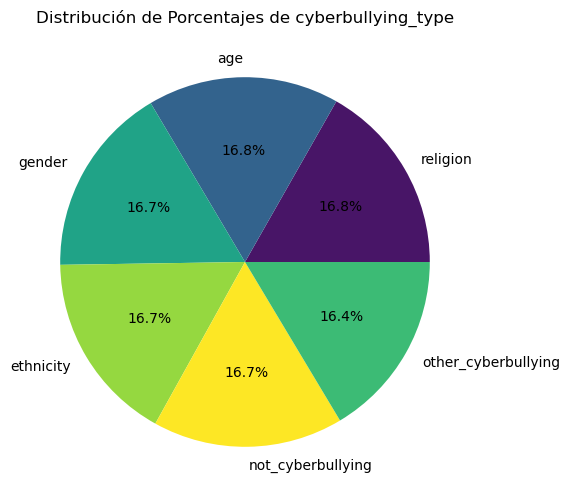

In [7]:
class_counts = df_raw['cyberbullying_type'].value_counts()
colors = ['#481567', '#33638D', '#20A387', '#95D840', '#FDE725', '#3CBB75']
plt.figure(figsize=(8, 6))
plt.pie(class_counts, labels=class_counts.index, autopct='%1.1f%%', colors=colors)
plt.title('Distribución de Porcentajes de cyberbullying_type')
plt.show()

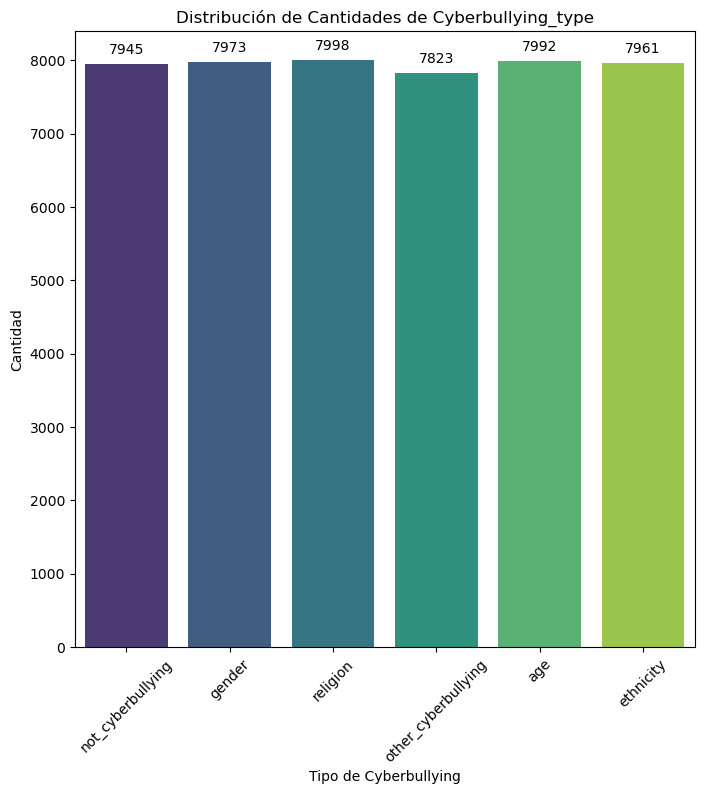

In [8]:
plt.figure(figsize=(8, 8))
ax = sns.countplot(data=df_raw, x='cyberbullying_type', palette='viridis')
plt.xticks(rotation=45)
plt.xlabel('Tipo de Cyberbullying')
plt.ylabel('Cantidad')
plt.title('Distribución de Cantidades de Cyberbullying_type')
for p in ax.patches:
    ax.text(
        p.get_x() + p.get_width() / 2,
        p.get_height() + 100,
        f'{int(p.get_height())}',
        ha='center',
        va='bottom'
    )

plt.show()

### Análisis de estadísticos

In [9]:
df_raw['text_length'] = df_raw['tweet_text'].apply(len)
df_raw

,tweet_text,cyberbullying_type,text_length
0,"In other words #katandandre, your food was cra...",not_cyberbullying,61
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying,115
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying,60
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying,103
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying,103
...,...,...,...
47687,"Black ppl aren't expected to do anything, depe...",ethnicity,234
47688,Turner did not withhold his disappointment. Tu...,ethnicity,276
47689,I swear to God. This dumb nigger bitch. I have...,ethnicity,104
47690,Yea fuck you RT @therealexel: IF YOURE A NIGGE...,ethnicity,90


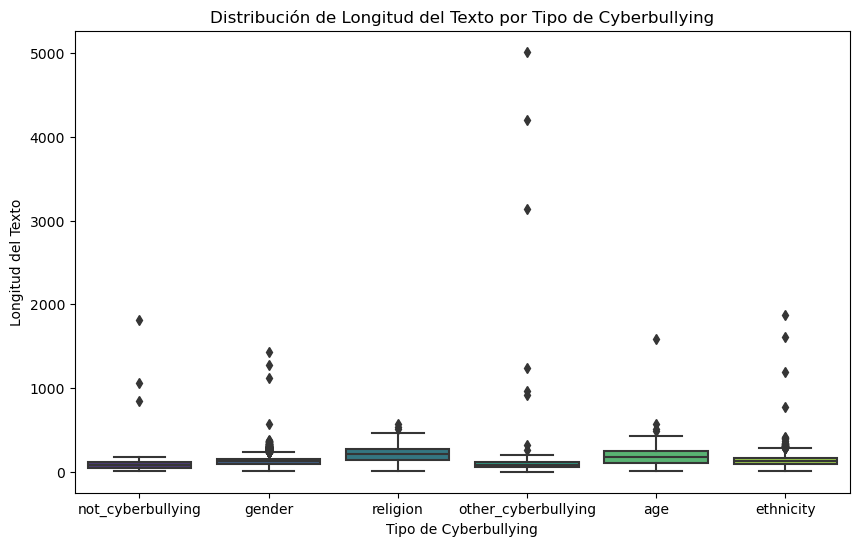

In [10]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_raw, x='cyberbullying_type', y='text_length' , palette='viridis')
plt.xlabel('Tipo de Cyberbullying')
plt.ylabel('Longitud del Texto')
plt.title('Distribución de Longitud del Texto por Tipo de Cyberbullying')
plt.show()

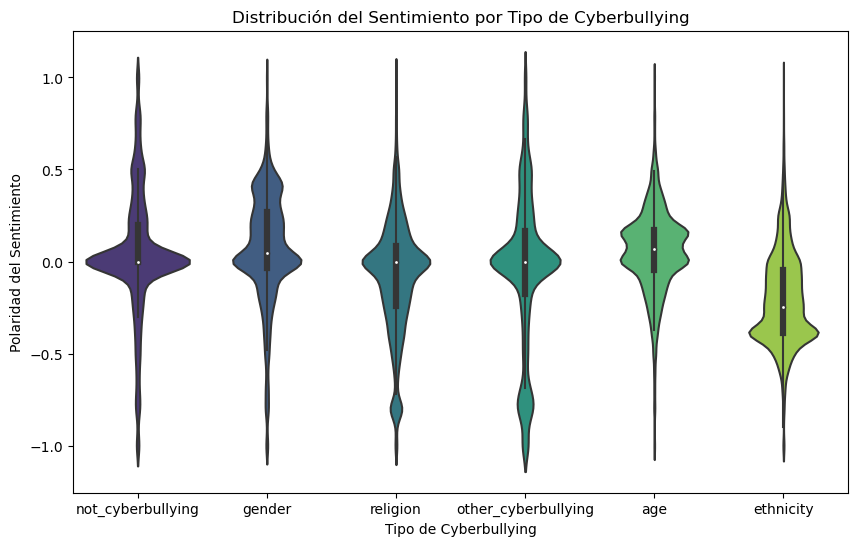

In [11]:
df_raw['sentiment'] = df_raw['tweet_text'].apply(lambda x: TextBlob(x).sentiment.polarity)

plt.figure(figsize=(10, 6))
sns.violinplot(data=df_raw, x='cyberbullying_type', y='sentiment', palette='viridis')
plt.xlabel('Tipo de Cyberbullying')
plt.ylabel('Polaridad del Sentimiento')
plt.title('Distribución del Sentimiento por Tipo de Cyberbullying')
plt.show()

In [12]:
df_raw

,tweet_text,cyberbullying_type,text_length,sentiment
0,"In other words #katandandre, your food was cra...",not_cyberbullying,61,-0.156250
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying,115,0.000000
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying,60,0.200000
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying,103,0.150000
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying,103,0.000000
...,...,...,...,...
47687,"Black ppl aren't expected to do anything, depe...",ethnicity,234,0.011905
47688,Turner did not withhold his disappointment. Tu...,ethnicity,276,-0.300000
47689,I swear to God. This dumb nigger bitch. I have...,ethnicity,104,-0.387500
47690,Yea fuck you RT @therealexel: IF YOURE A NIGGE...,ethnicity,90,-0.458333


### Mapeamos las etiquetas de texto en valores numéricos.


In [13]:
cyberbullying_classes = {
    "not_cyberbullying": 0,
    "gender": 1,
    "religion": 2,
    "other_cyberbullying": 3,
    "age": 4,
    "ethnicity": 5
}

df_raw['cyberbullying_numeric_type'] = df_raw['cyberbullying_type'].map(cyberbullying_classes)

In [14]:
df_raw.tail()

,tweet_text,cyberbullying_type,text_length,sentiment,cyberbullying_numeric_type
47687,"Black ppl aren't expected to do anything, depe...",ethnicity,234,0.011905,5
47688,Turner did not withhold his disappointment. Tu...,ethnicity,276,-0.300000,5
47689,I swear to God. This dumb nigger bitch. I have...,ethnicity,104,-0.387500,5
47690,Yea fuck you RT @therealexel: IF YOURE A NIGGE...,ethnicity,90,-0.458333,5
47691,Bro. U gotta chill RT @CHILLShrammy: Dog FUCK ...,ethnicity,76,-0.058333,5


### Preprocesamiento

In [15]:
nltk.download('punkt')
nltk.download('stopwords')

# Define la función clean_tweet
def clean_tweet(tweet:str) -> str:
    tweet = re.sub(r'http\S+|www\S+|https\S+', '', tweet, flags=re.MULTILINE) # Remove urls
    tweet = re.sub(r'@[A-Za-z0-9]+','', tweet) # Remove @mentions
    tweet = re.sub(r'\#[A-Za-z0-9]+','', tweet) # Remove hashtags
    tweet = re.sub(r'[^a-zA-Z\s]', '', tweet) # Remove special characters and punctuation
    tweet = tweet.lower() # Convert to lowercase

    tokens = word_tokenize(tweet) # Tokenize

    stop_words = set(stopwords.words('english')) # Remove stopwords
    filtered_tokens = [word for word in tokens if word.lower() not in stop_words]

    clean_tweet = ' '.join(filtered_tokens) # Join tokens back into string

    return clean_tweet


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/noeliaqualindi/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/noeliaqualindi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Se aplica la función clean_tweet a la columna 'tweet_text' y limpiamos los tweets de urls y caracteres especiales


In [16]:
df_raw['clean_tweet'] = df_raw['tweet_text'].apply(clean_tweet)

# mostramos los primeros registros del dataframe limpio
df_raw.head()

,tweet_text,cyberbullying_type,text_length,sentiment,cyberbullying_numeric_type,clean_tweet
0,"In other words #katandandre, your food was cra...",not_cyberbullying,61,-0.15625,0,words food crapilicious
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying,115,0.00000,0,white
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying,60,0.20000,0,classy whore red velvet cupcakes
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying,103,0.15000,0,gio meh p thanks heads concerned another angry...
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying,103,0.00000,0,isis account pretending kurdish account like i...


### Contabilización de palabras

In [17]:
def words_bar_charts(dataframe: pd.DataFrame, cyberbullying_classes: dict):
    num_classes = len(cyberbullying_classes)


    fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 12), sharey=True)

    axes = axes.ravel()

    viridis_colors = plt.cm.viridis(np.linspace(0, 1, num_classes))

    for i, (ax, (cyberbullying_type, value)) in enumerate(zip(axes, cyberbullying_classes.items())):
        df_filter = dataframe[dataframe['cyberbullying_numeric_type'] == value]

        text = ' '.join(df_filter['clean_tweet'].to_list())
        words = text.split()
        word_counts = Counter(words)
        top_words = word_counts.most_common(20)
        words, counts = zip(*top_words)

        ax.bar(words, counts, color=viridis_colors[i])
        ax.set_title(f'Top 20 palabras en tweets de tipo "{cyberbullying_type}"')
        ax.set_xlabel('Palabra')
        ax.set_ylabel('Cantidad')
        ax.tick_params(axis='x', rotation=45)

    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()


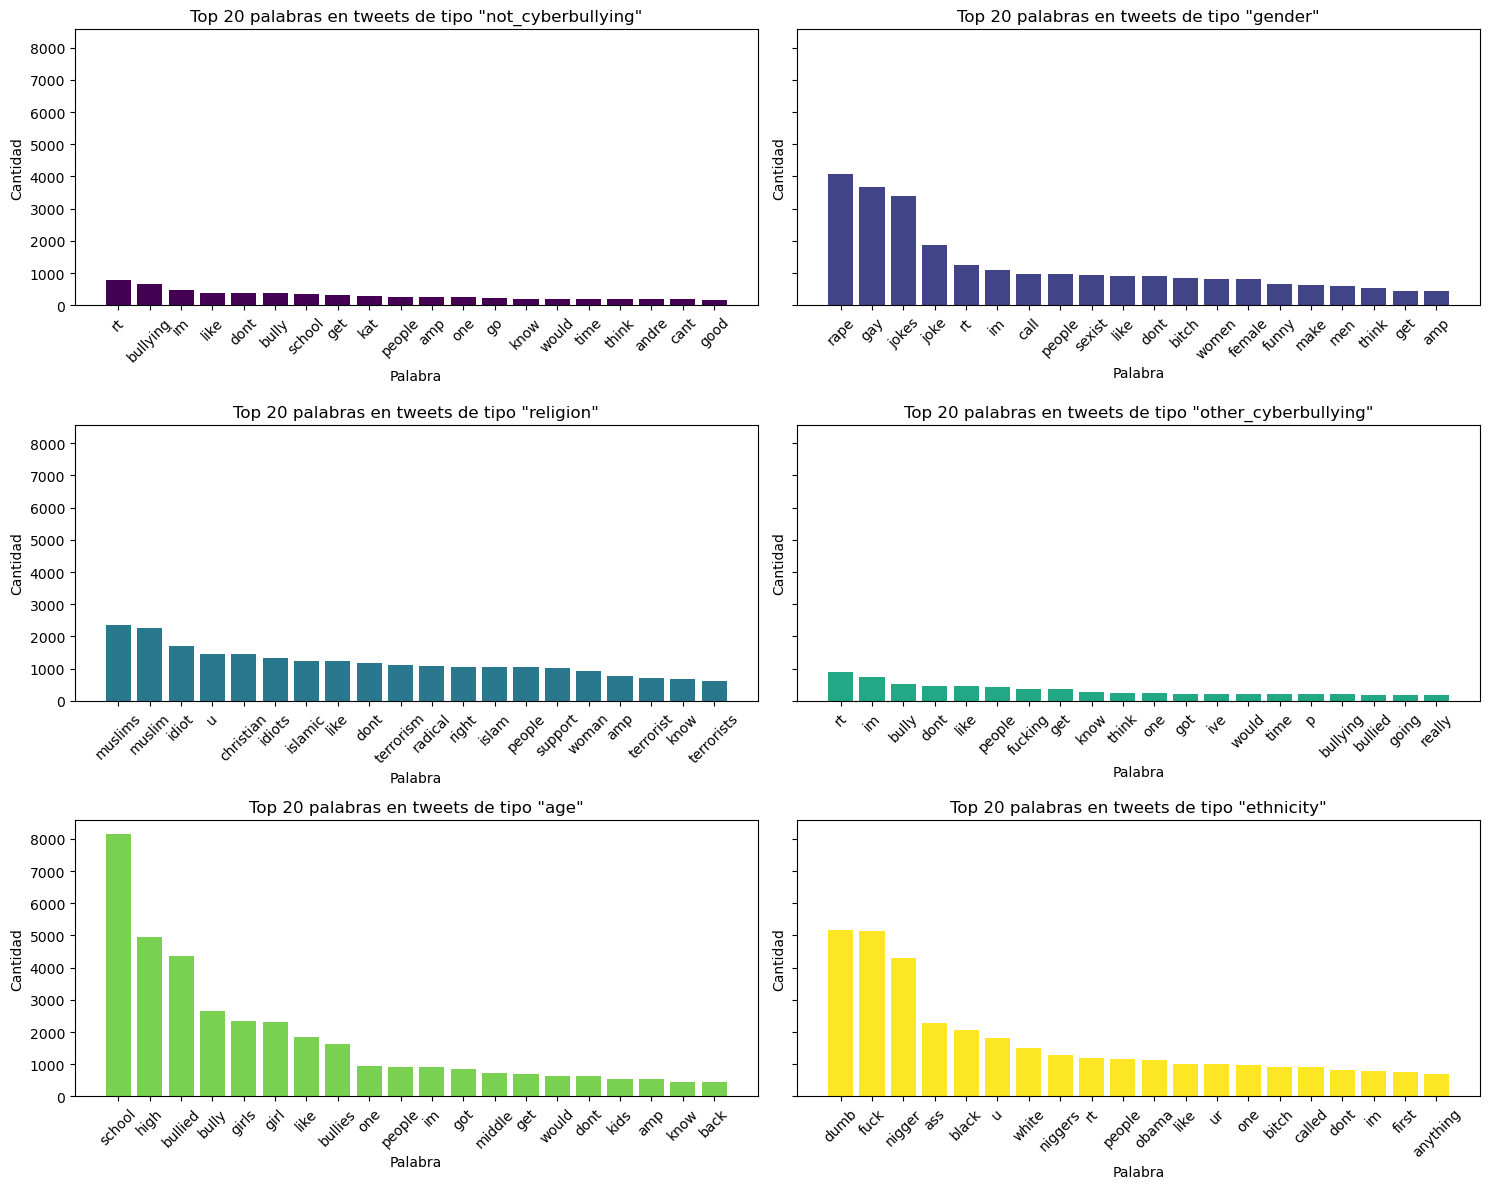

In [18]:
words_bar_charts(df_raw, cyberbullying_classes)

In [19]:
def wordcloud_subplots(dataframe: pd.DataFrame, cyberbullying_classes: dict):
    fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 12))

    axes = axes.ravel()

    for ax, (cyberbullying_type, value) in zip(axes, cyberbullying_classes.items()):
        df_filter = dataframe[dataframe['cyberbullying_numeric_type'] == value]

        text = ' '.join(df_filter['clean_tweet'].to_list())

        wordcloud = WordCloud(width=800, height=400, background_color='black').generate(text)

        ax.imshow(wordcloud, interpolation='bilinear')
        ax.set_title(f'Nube de palabras para "{cyberbullying_type}"')
        ax.axis('off')

    for i in range(len(cyberbullying_classes), len(axes)):
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

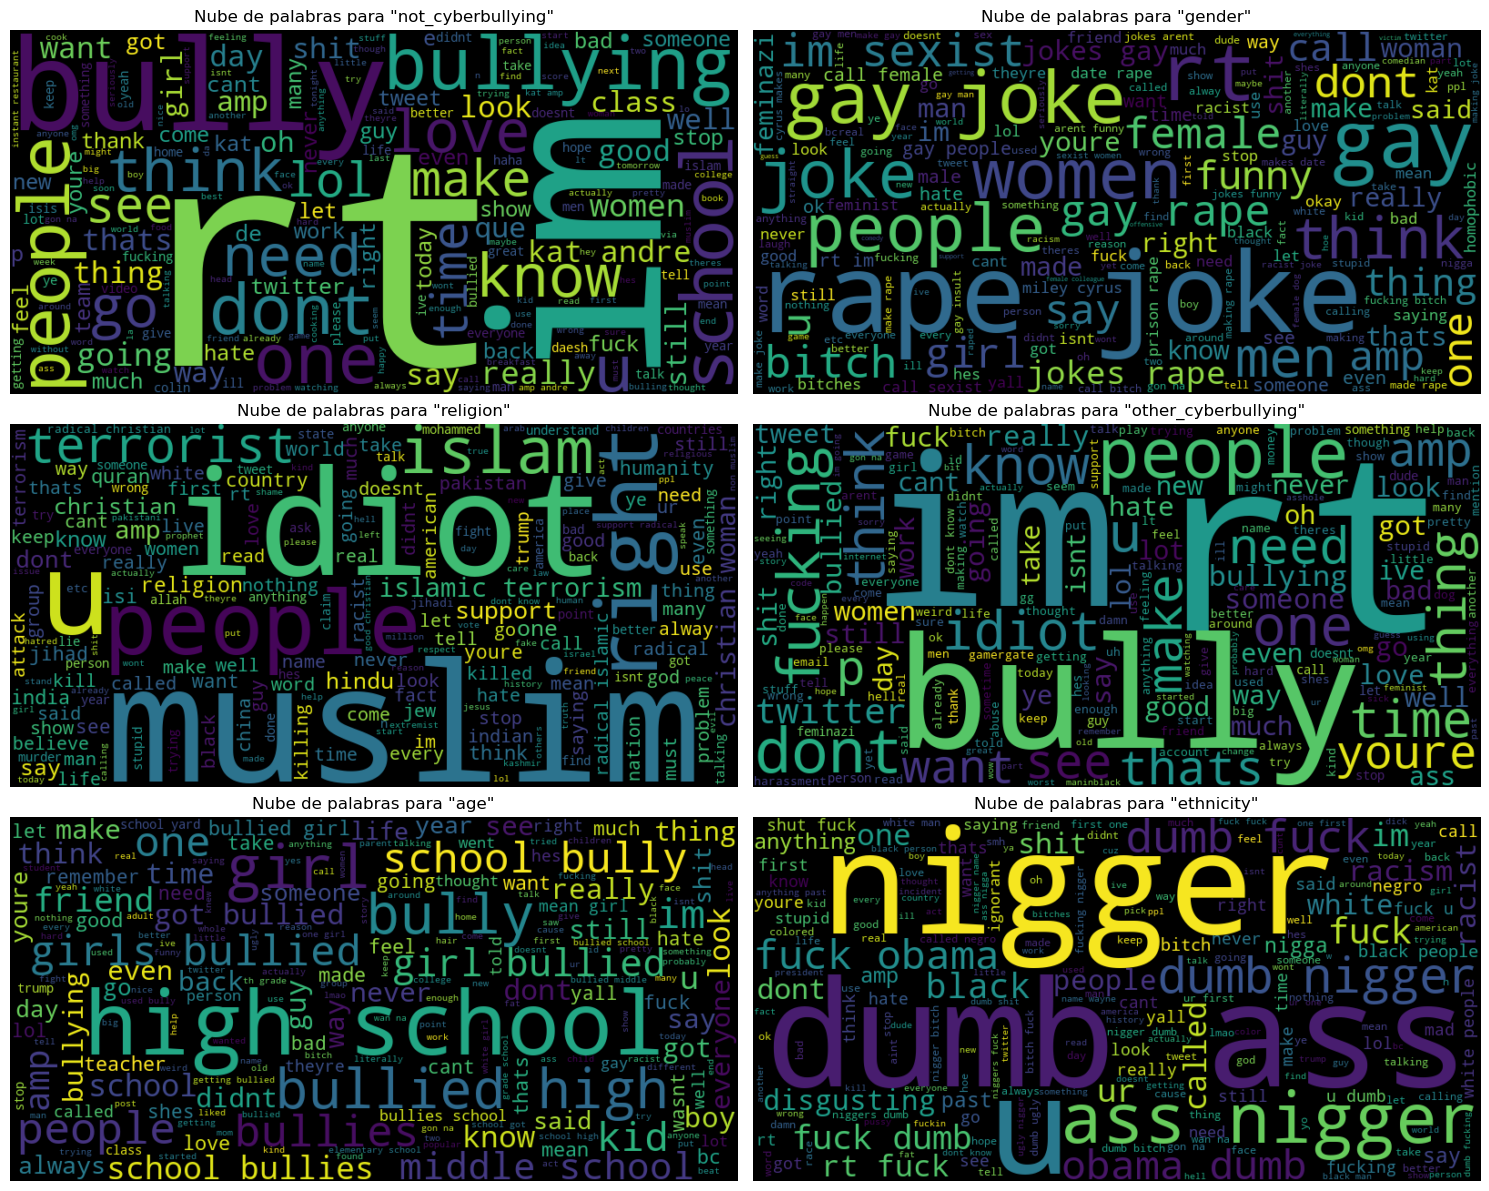

In [20]:
wordcloud_subplots(df_raw, cyberbullying_classes)

### Análisis, detección y tratamiento de Outliers

In [21]:
nlp = spacy.load("en_core_web_sm")
# Función para extraer estadísticas de un tweet
def analyze_tweet_(text):
    doc = nlp(text)
    num_tokens = len(doc)
    num_words = len([token for token in doc if token.is_alpha])
    num_chars = len(text)
    num_stopwords = len([token for token in doc if token.is_stop])
    num_nouns = len([token for token in doc if token.pos_ == "NOUN"])
    num_verbs = len([token for token in doc if token.pos_ == "VERB"])

    return {
        'num_tokens': num_tokens,
        'num_words': num_words,
        'num_chars': num_chars,
        'num_stopwords': num_stopwords,
        'num_nouns': num_nouns,
        'num_verbs': num_verbs
    }

In [22]:
# Aplicar la función a cada tweet en el DataFrame
stats = df_raw['clean_tweet'].apply(analyze_tweet_)

# Convertir la lista de diccionarios en un DataFrame
stats_df = pd.DataFrame(list(stats))

df_preprocessed = df_raw.copy()
# Añadir las estadísticas al DataFrame original
for column in stats_df.columns:
    df_preprocessed[column] = stats_df[column]

In [23]:
df_preprocessed

,tweet_text,cyberbullying_type,text_length,sentiment,cyberbullying_numeric_type,clean_tweet,num_tokens,num_words,num_chars,num_stopwords,num_nouns,num_verbs
0,"In other words #katandandre, your food was cra...",not_cyberbullying,61,-0.156250,0,words food crapilicious,3,3,23,0,2,0
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying,115,0.000000,0,white,1,1,5,0,0,0
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying,60,0.200000,0,classy whore red velvet cupcakes,5,5,32,0,3,0
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying,103,0.150000,0,gio meh p thanks heads concerned another angry...,10,10,59,1,5,1
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying,103,0.000000,0,isis account pretending kurdish account like i...,8,8,55,0,3,2
...,...,...,...,...,...,...,...,...,...,...,...,...
47687,"Black ppl aren't expected to do anything, depe...",ethnicity,234,0.011905,5,black ppl arent expected anything depended any...,23,23,153,5,5,5
47688,Turner did not withhold his disappointment. Tu...,ethnicity,276,-0.300000,5,turner withhold disappointment turner called c...,29,29,206,4,12,6
47689,I swear to God. This dumb nigger bitch. I have...,ethnicity,104,-0.387500,5,swear god dumb nigger bitch got bleach hair re...,13,13,73,0,6,2
47690,Yea fuck you RT @therealexel: IF YOURE A NIGGE...,ethnicity,90,-0.458333,5,yea fuck rt youre nigger fucking unfollow fuck...,11,11,62,2,3,1


In [24]:
# Añadir tokenización y lematización
df_preprocessed['tokens'] = df_preprocessed['clean_tweet'].apply(lambda text: [token.text for token in nlp(text)])
df_preprocessed['lemmas'] = df_preprocessed['clean_tweet'].apply(lambda text: [token.lemma_ for token in nlp(text)])

In [25]:
# Función para detectar outliers usando el IQR
def detect_outliers_(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] < lower_bound) | (df[column] > upper_bound)]

In [26]:
# Detectar outliers en las columnas numéricas
outliers_num_tokens = detect_outliers_(df_preprocessed, 'num_tokens')
outliers_num_words = detect_outliers_(df_preprocessed, 'num_words')
outliers_num_chars = detect_outliers_(df_preprocessed, 'num_chars')

# Opcional: Tratar los outliers (por ejemplo, eliminarlos)
# df_cleaned = df_raw[~df_raw.index.isin(outliers_num_tokens.index)]
# df_cleaned = df_cleaned[~df_cleaned.index.isin(outliers_num_words.index)]
# df_cleaned = df_cleaned[~df_cleaned.index.isin(outliers_num_chars.index)]

# Mostrar el DataFrame resultante
df_preprocessed

,tweet_text,cyberbullying_type,text_length,sentiment,cyberbullying_numeric_type,clean_tweet,num_tokens,num_words,num_chars,num_stopwords,num_nouns,num_verbs,tokens,lemmas
0,"In other words #katandandre, your food was cra...",not_cyberbullying,61,-0.156250,0,words food crapilicious,3,3,23,0,2,0,"[words, food, crapilicious]","[word, food, crapilicious]"
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying,115,0.000000,0,white,1,1,5,0,0,0,[white],[white]
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying,60,0.200000,0,classy whore red velvet cupcakes,5,5,32,0,3,0,"[classy, whore, red, velvet, cupcakes]","[classy, whore, red, velvet, cupcake]"
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying,103,0.150000,0,gio meh p thanks heads concerned another angry...,10,10,59,1,5,1,"[gio, meh, p, thanks, heads, concerned, anothe...","[gio, meh, p, thank, head, concern, another, a..."
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying,103,0.000000,0,isis account pretending kurdish account like i...,8,8,55,0,3,2,"[isis, account, pretending, kurdish, account, ...","[isis, account, pretend, kurdish, account, lik..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47687,"Black ppl aren't expected to do anything, depe...",ethnicity,234,0.011905,5,black ppl arent expected anything depended any...,23,23,153,5,5,5,"[black, ppl, are, nt, expected, anything, depe...","[black, ppl, be, not, expect, anything, depend..."
47688,Turner did not withhold his disappointment. Tu...,ethnicity,276,-0.300000,5,turner withhold disappointment turner called c...,29,29,206,4,12,6,"[turner, withhold, disappointment, turner, cal...","[turner, withhold, disappointment, turner, cal..."
47689,I swear to God. This dumb nigger bitch. I have...,ethnicity,104,-0.387500,5,swear god dumb nigger bitch got bleach hair re...,13,13,73,0,6,2,"[swear, god, dumb, nigger, bitch, got, bleach,...","[swear, god, dumb, nigger, bitch, get, bleach,..."
47690,Yea fuck you RT @therealexel: IF YOURE A NIGGE...,ethnicity,90,-0.458333,5,yea fuck rt youre nigger fucking unfollow fuck...,11,11,62,2,3,1,"[yea, fuck, rt, you, re, nigger, fucking, unfo...","[yea, fuck, rt, you, re, nigger, fucking, unfo..."


In [27]:
df_preprocessed.describe()

,text_length,sentiment,cyberbullying_numeric_type,num_tokens,num_words,num_chars,num_stopwords,num_nouns,num_verbs
count,47692.000000,47692.000000,47692.000000,47692.000000,47692.000000,47692.000000,47692.000000,47692.000000,47692.000000
mean,136.253229,-0.027226,2.499602,13.502831,13.502831,82.619748,1.811897,4.518871,2.878177
std,85.226899,0.324770,1.708993,8.906402,8.906402,56.677206,1.979130,3.375993,2.319892
min,1.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,78.000000,-0.192857,1.000000,7.000000,7.000000,43.000000,0.000000,2.000000,1.000000
50%,124.000000,0.000000,2.000000,12.000000,12.000000,70.000000,1.000000,4.000000,2.000000
75%,180.000000,0.158688,4.000000,19.000000,19.000000,114.000000,3.000000,6.000000,4.000000
max,5018.000000,1.000000,5.000000,428.000000,428.000000,2652.000000,71.000000,142.000000,91.000000


### Eliminamos tweets de 1 sola palabra

In [28]:
df_final = df_raw.copy()

In [29]:
df_final['word_count'] = df_final['clean_tweet'].apply(lambda x: len(str(x).split()))
df_final = df_final[df_final['word_count'] > 1]

In [30]:
df_final.shape

(46396, 7)

### Eliminamos tweets catalogados como other_cyberbullying

In [31]:
df_final= df_final[df_final['cyberbullying_type'] != 'other_cyberbullying']

In [32]:
df_final.shape

(39256, 7)

In [33]:
categorias_unicas = df_final.iloc[:, 1].unique()

print("Categorías existentes en la columna cyberbullying_type:")
for categoria in categorias_unicas:
    print(categoria)

Categorías existentes en la columna cyberbullying_type:
not_cyberbullying
gender
religion
age
ethnicity


### Actualizamos las clases mapeadas a numéricas

In [34]:
# Verificar el conteo de instancias por clase actualizado
cyberbullying_classes_final = {
    "not_cyberbullying": 0,
    "gender": 1,
    "religion": 2,
    "age": 3,
    "ethnicity": 4
}

# Asignar los valores numéricos a la columna cyberbullying_numeric_type
df_final['cyberbullying_numeric_type'] = df_final['cyberbullying_type'].map(cyberbullying_classes_final)

# Conteo de instancias por clase
for clase, valor in cyberbullying_classes_final.items():
    print(f"Clase {clase} ({valor}): {df_final[df_final['cyberbullying_numeric_type'] == valor].shape[0]} instancias")

Clase not_cyberbullying (0): 7483 instancias
Clase gender (1): 7838 instancias
Clase religion (2): 7994 instancias
Clase age (3): 7990 instancias
Clase ethnicity (4): 7951 instancias


In [35]:
df_final

,tweet_text,cyberbullying_type,text_length,sentiment,cyberbullying_numeric_type,clean_tweet,word_count
0,"In other words #katandandre, your food was cra...",not_cyberbullying,61,-0.156250,0,words food crapilicious,3
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying,60,0.200000,0,classy whore red velvet cupcakes,5
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying,103,0.150000,0,gio meh p thanks heads concerned another angry...,10
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying,103,0.000000,0,isis account pretending kurdish account like i...,8
5,"@Raja5aab @Quickieleaks Yes, the test of god i...",not_cyberbullying,131,-0.050000,0,yes test god good bad indifferent weird whatev...,11
...,...,...,...,...,...,...,...
47687,"Black ppl aren't expected to do anything, depe...",ethnicity,234,0.011905,4,black ppl arent expected anything depended any...,22
47688,Turner did not withhold his disappointment. Tu...,ethnicity,276,-0.300000,4,turner withhold disappointment turner called c...,29
47689,I swear to God. This dumb nigger bitch. I have...,ethnicity,104,-0.387500,4,swear god dumb nigger bitch got bleach hair re...,13
47690,Yea fuck you RT @therealexel: IF YOURE A NIGGE...,ethnicity,90,-0.458333,4,yea fuck rt youre nigger fucking unfollow fuck...,10


### Verificamos nuevamente balanceo de clases luego de la limpieza y preprocesamiento

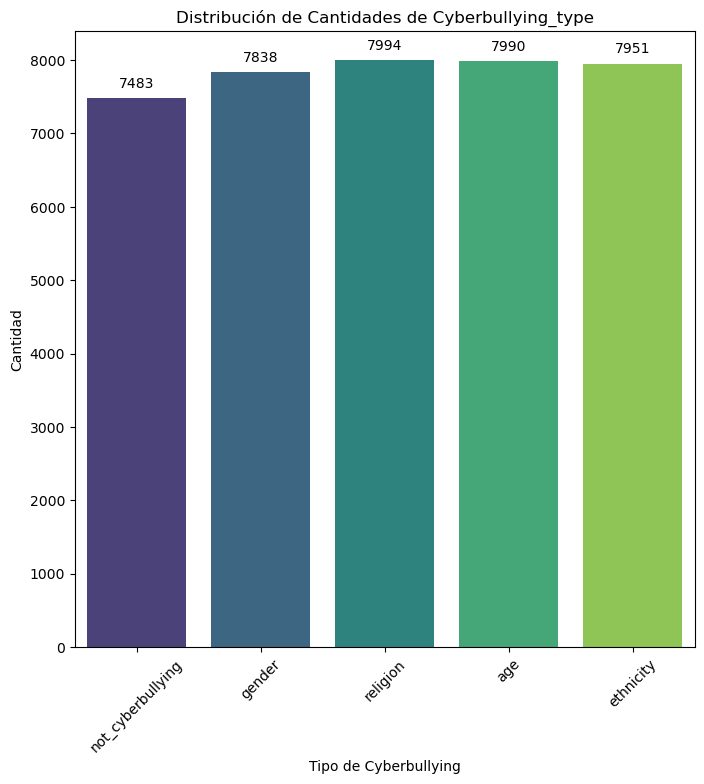

In [36]:
plt.figure(figsize=(8, 8))
ax = sns.countplot(data=df_final, x='cyberbullying_type', palette='viridis')
plt.xticks(rotation=45)
plt.xlabel('Tipo de Cyberbullying')
plt.ylabel('Cantidad')
plt.title('Distribución de Cantidades de Cyberbullying_type')
for p in ax.patches:
    ax.text(
        p.get_x() + p.get_width() / 2,
        p.get_height() + 100,
        f'{int(p.get_height())}',
        ha='center',
        va='bottom'
    )

plt.show()

## MODELADO

## DistilBert  
Versión más pequeña y rápida de BERT que retiene el 97% del rendimiento de BERT pero es más eficiente computacionalmente.

Ideal para: Entornos con limitaciones de recursos.

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.218500,0.201864,0.931864,0.936597,0.931864,0.933056
2,0.172800,0.185449,0.936067,0.936647,0.936067,0.936324
3,0.117800,0.242780,0.923841,0.923626,0.923841,0.922144
4,0.046400,0.282568,0.937468,0.937780,0.937468,0.937600
5,0.039000,0.372415,0.935685,0.935870,0.935685,0.935708


Resultados de evaluación: {'eval_loss': 0.18544864654541016, 'eval_accuracy': 0.9360672440142639, 'eval_precision': 0.9366465209820778, 'eval_recall': 0.9360672440142639, 'eval_f1': 0.9363237073895501, 'eval_runtime': 29.939, 'eval_samples_per_second': 262.267, 'eval_steps_per_second': 8.217, 'epoch': 5.0}


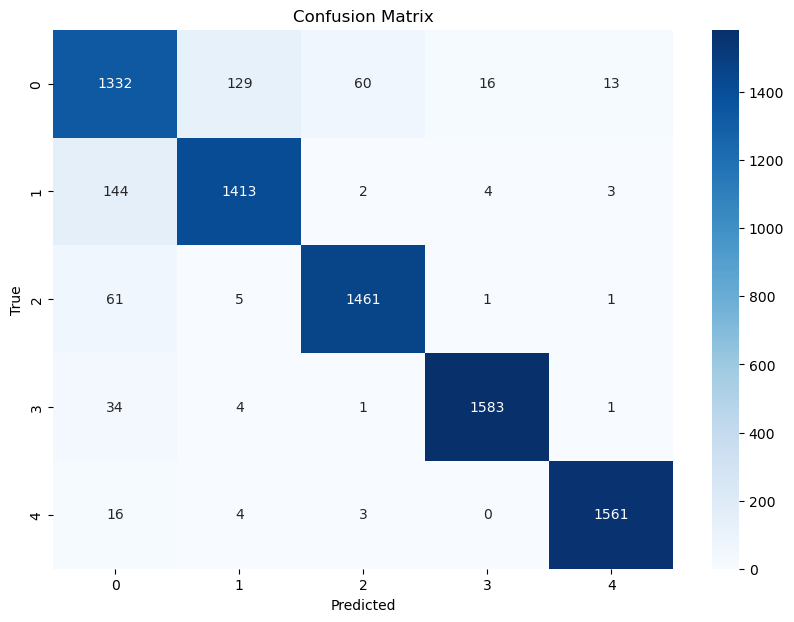

In [41]:
# Configuración de CUDA para poder debuggear
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

# Definir el tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# Tokenizar los datos
def tokenize_tweets(tweets):
    return tokenizer(tweets.tolist(), padding=True, truncation=True, return_tensors='pt')

# Dataset personalizado para Pytorch
class TweetDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# Dividir los datos en conjuntos de entrenamiento y validación
train_df, val_df = train_test_split(df_final, test_size=0.2, random_state=42)

train_encodings = tokenizer(train_df['clean_tweet'].tolist(), padding=True, truncation=True, return_tensors='pt')
val_encodings = tokenizer(val_df['clean_tweet'].tolist(), padding=True, truncation=True, return_tensors='pt')

train_dataset = TweetDataset(train_encodings, train_df['cyberbullying_numeric_type'].values)
val_dataset = TweetDataset(val_encodings, val_df['cyberbullying_numeric_type'].values)

# Inicializar el modelo
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=5)
model.to('cuda')

# Configuración del entrenamiento con early stopping
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=10,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    eval_strategy='epoch',
    save_strategy='epoch',
    save_total_limit=1,
    load_best_model_at_end=True,
    metric_for_best_model='eval_loss',
    greater_is_better=False,
)

# Métricas de evaluación
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'f1': f1,
    }

# Inicializar el entrenador con early stopping
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]  # Early stopping con paciencia de 3 épocas
)

# Entrenar el modelo
trainer.train()

# Evaluar el modelo
eval_result = trainer.evaluate()

# Obtener las predicciones
preds = trainer.predict(val_dataset)
labels_list = (val_df['cyberbullying_numeric_type'].values, preds.predictions.argmax(-1))

# Mostrar los resultados
print(f"Resultados de evaluación: {eval_result}")

# Calcular y mostrar la matriz de confusión
conf_matrix = confusion_matrix(labels_list[0], labels_list[1])
df_cm = pd.DataFrame(conf_matrix, index=[i for i in range(num_classes)], columns=[i for i in range(num_classes)])

plt.figure(figsize=(10, 7))
sns.heatmap(df_cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

## BERT

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

C:\ProgramData\anaconda3\envs\myenv\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\ProgramData\anaconda3\envs\myenv\Lib\site-packages\transformers\models\bert\modeling_bert.py:435: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.257800,0.232804,0.932374,0.934515,0.932374,0.933179
2,0.213400,0.218318,0.930973,0.931179,0.930973,0.930988
3,0.062200,0.262064,0.938869,0.939245,0.938869,0.938885
4,0.065200,0.325163,0.936067,0.937141,0.936067,0.936414
5,0.066700,0.395747,0.932756,0.932128,0.932756,0.932160


Resultados de evaluación: {'eval_loss': 0.21831759810447693, 'eval_accuracy': 0.9309730005094243, 'eval_precision': 0.9311788276430739, 'eval_recall': 0.9309730005094243, 'eval_f1': 0.9309877542486363, 'eval_runtime': 57.8712, 'eval_samples_per_second': 135.681, 'eval_steps_per_second': 8.484, 'epoch': 5.0}


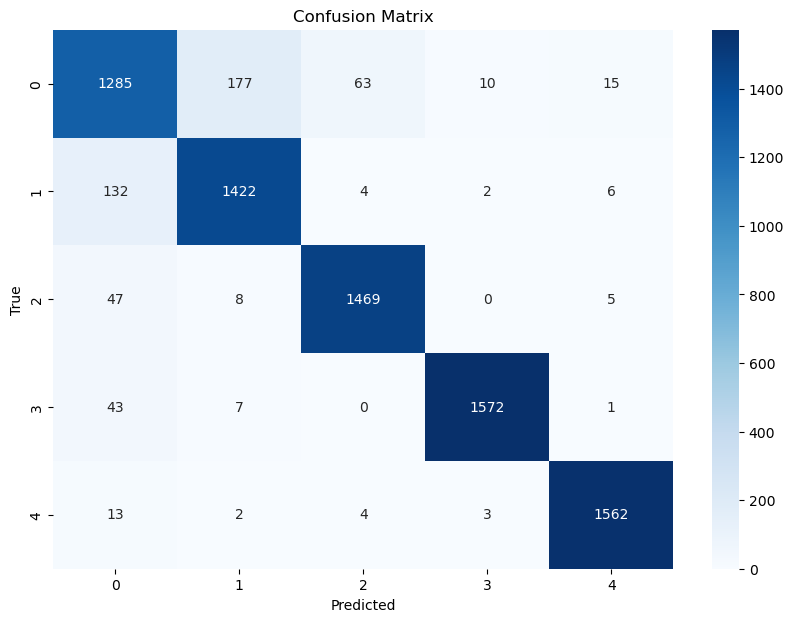

In [39]:
import os
import torch
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_recall_fscore_support
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments, EarlyStoppingCallback
from torch.utils.data import Dataset

# Configuración de CUDA para poder debuggear
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

# Definir el tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenizar los datos
def tokenize_tweets(tweets):
    return tokenizer(tweets.tolist(), padding=True, truncation=True, return_tensors='pt')

# Dataset personalizado para Pytorch
class TweetDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# Dividir los datos en conjuntos de entrenamiento y validación
train_df, val_df = train_test_split(df_final, test_size=0.2, random_state=42)

train_encodings = tokenize_tweets(train_df['clean_tweet'])
val_encodings = tokenize_tweets(val_df['clean_tweet'])

train_dataset = TweetDataset(train_encodings, train_df['cyberbullying_numeric_type'].values)
val_dataset = TweetDataset(val_encodings, val_df['cyberbullying_numeric_type'].values)

# Inicializar el modelo
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=5)
model.to('cuda')

# Configuración del entrenamiento con early stopping
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=10,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    eval_strategy='epoch',
    save_strategy='epoch',
    save_total_limit=1,
    load_best_model_at_end=True,
    metric_for_best_model='eval_loss',
    greater_is_better=False,
)

# Métricas de evaluación
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'f1': f1,
    }

# Inicializar el entrenador con early stopping
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]  # Early stopping con paciencia de 3 épocas
)

# Entrenar el modelo
trainer.train()

# Evaluar el modelo
eval_result = trainer.evaluate()

# Obtener las predicciones
preds = trainer.predict(val_dataset)
labels_list = (val_df['cyberbullying_numeric_type'].values, preds.predictions.argmax(-1))

# Mostrar los resultados
print(f"Resultados de evaluación: {eval_result}")

# Calcular y mostrar la matriz de confusión
conf_matrix = confusion_matrix(labels_list[0], labels_list[1])
df_cm = pd.DataFrame(conf_matrix, index=[i for i in range(num_classes)], columns=[i for i in range(num_classes)])

plt.figure(figsize=(10, 7))
sns.heatmap(df_cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

## RNN
CAPAS:  
Embedding (GloVe)  
Conv1D  
MaxPooling1D
LSTM
Dense  
Dropout
Dense  
Dropout
Dense (Softmax)

In [20]:
import pickle
# Cargar embeddings preentrenados de GloVe para Twitter : modelo GloVe de Stanford, que tiene una versión entrenada en 2 mil millones de tweets.
embedding_dim = 100
embedding_index = {}
pkl_file = 'C:\\Users\\-MSI-\\Desktop\\glove.twitter.27B.100d.pkl\\glove.twitter.27B.100d.pkl'


# Cargar el archivo .pkl
with open(pkl_file, 'rb') as f:
    embedding_index = pickle.load(f)

# Crear la matriz de embedding
def create_embedding_matrix(tokenizer, max_words, embedding_dim, embedding_index):
    embedding_matrix = np.zeros((max_words, embedding_dim))
    for word, i in tokenizer.word_index.items():
        if i < max_words:
            embedding_vector = embedding_index.get(word)
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector
    return embedding_matrix


Epoch 1/20


C:\ProgramData\anaconda3\envs\myenv\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


982/982 ━━━━━━━━━━━━━━━━━━━━ 66s 63ms/step - accuracy: 0.7004 - loss: 0.9403 - val_accuracy: 0.9003 - val_loss: 0.4106 - learning_rate: 0.0010
Epoch 2/20
982/982 ━━━━━━━━━━━━━━━━━━━━ 66s 68ms/step - accuracy: 0.9123 - loss: 0.3683 - val_accuracy: 0.9214 - val_loss: 0.3004 - learning_rate: 0.0010
Epoch 3/20
982/982 ━━━━━━━━━━━━━━━━━━━━ 64s 65ms/step - accuracy: 0.9281 - loss: 0.2884 - val_accuracy: 0.9258 - val_loss: 0.2769 - learning_rate: 0.0010
Epoch 4/20
982/982 ━━━━━━━━━━━━━━━━━━━━ 67s 68ms/step - accuracy: 0.9374 - loss: 0.2363 - val_accuracy: 0.9196 - val_loss: 0.3079 - learning_rate: 0.0010
Epoch 5/20
982/982 ━━━━━━━━━━━━━━━━━━━━ 64s 65ms/step - accuracy: 0.9458 - loss: 0.2099 - val_accuracy: 0.9153 - val_loss: 0.3014 - learning_rate: 0.0010
Epoch 6/20
982/982 ━━━━━━━━━━━━━━━━━━━━ 68s 69ms/step - accuracy: 0.9577 - loss: 0.1660 - val_accuracy: 0.9263 - val_loss: 0.3199 - learning_rate: 2.0000e-04
246/246 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step
{'0': {'precision': 0.8044627128596594, '

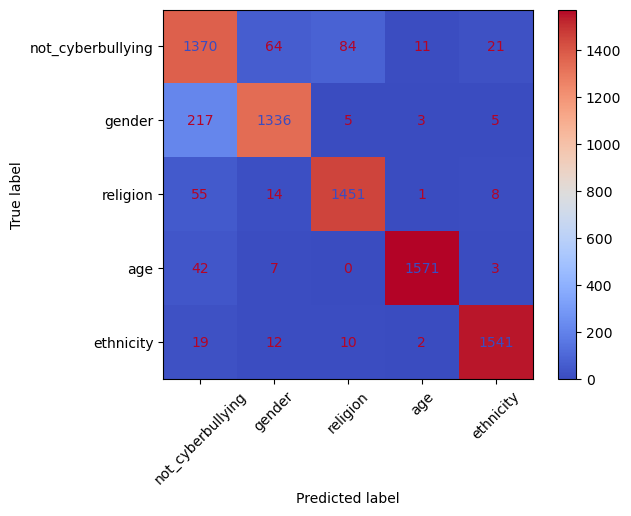

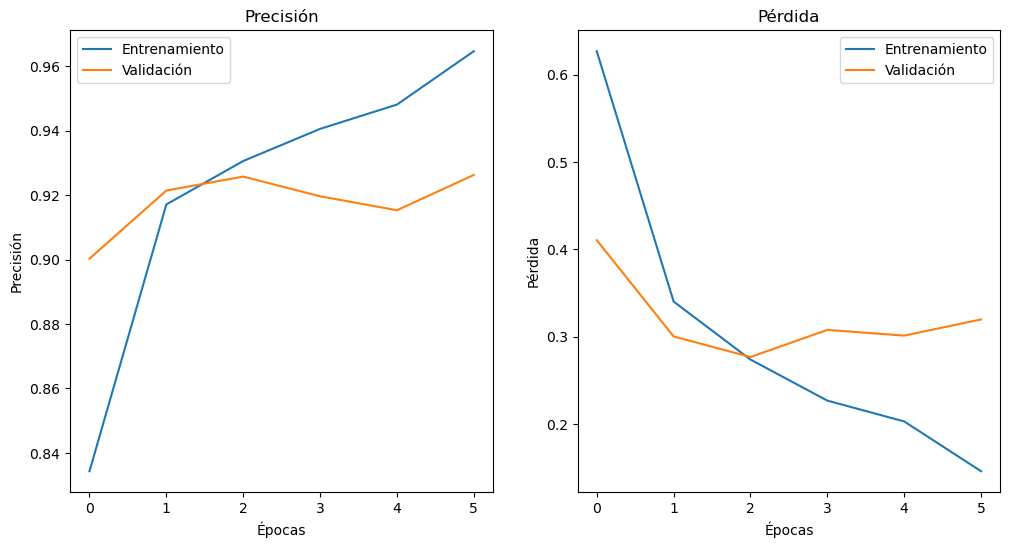

In [ ]:
# Configuración de CUDA para poder debuggear
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

# Tokenización de los tweets
max_words = 10000
max_len = 100
embedding_dim = 100
num_classes = 5  # Ajusta esto al número de clases en tu dataset

tokenizer = Tokenizer(num_words=max_words, lower=True, oov_token="<OOV>")
tokenizer.fit_on_texts(train_df['clean_tweet'])

train_sequences = tokenizer.texts_to_sequences(train_df['clean_tweet'])
train_padded = pad_sequences(train_sequences, maxlen=max_len)

val_sequences = tokenizer.texts_to_sequences(val_df['clean_tweet'])
val_padded = pad_sequences(val_sequences, maxlen=max_len)

# Definir las etiquetas
train_labels = np.array(train_df['cyberbullying_numeric_type'])
val_labels = np.array(val_df['cyberbullying_numeric_type'])

embedding_matrix = create_embedding_matrix(tokenizer, max_words, embedding_dim, embedding_index)

# Definir la red con embeddings preentrenados
model = Sequential([
    Embedding(input_dim=max_words,
              output_dim=embedding_dim,
              input_length=max_len,
              embeddings_initializer=Constant(embedding_matrix),
              trainable=False),
    Conv1D(256, 3, activation='relu'),
    MaxPooling1D(pool_size=2),
    LSTM(256, return_sequences=True),
    LSTM(128),
    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    Dense(32, activation='relu', kernel_regularizer=l2(0.001)),
    Dense(num_classes, activation='softmax')
])

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Entrenar el modelo
history = model.fit(train_padded, train_labels, epochs=20, batch_size=32, validation_data=(val_padded, val_labels), verbose=1, callbacks=[early_stopping])

# Evaluar el modelo
val_predictions = model.predict(val_padded)
val_predicted_labels = np.argmax(val_predictions, axis=1)

# Clasificación
report = classification_report(val_labels, val_predicted_labels, output_dict=True)
print(report)

# Matriz de confusión
conf_matrix = confusion_matrix(val_labels, val_predicted_labels,labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=classes)
disp.plot(cmap='coolwarm')
plt.xticks(rotation=45)
plt.show()

# Graficar precisión y pérdida
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validación')
plt.title('Precisión')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.title('Pérdida')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

## Embedding GloVe

In [ ]:
# Parámetros
max_words = 20000
max_len = 100
embedding_dim = 100

import pickle
# Cargar embeddings preentrenados de GloVe para Twitter : modelo GloVe de Stanford, que tiene una versión entrenada en 2 mil millones de tweets.
embedding_dim = 100
embedding_index = {}
pkl_file = 'C:\\Users\\-MSI-\\Desktop\\glove.twitter.27B.100d.pkl\\glove.twitter.27B.100d.pkl'

# Cargar el archivo .pkl
with open(pkl_file, 'rb') as f:
    embedding_index = pickle.load(f)

# Crear el tokenizer
tokenizer = Tokenizer(num_words=max_words, lower=True, oov_token="<OOV>")
tokenizer.fit_on_texts(df_final['clean_tweet'])

# Convertir textos a secuencias y rellenar
sequences = tokenizer.texts_to_sequences(df_final['clean_tweet'])
padded_sequences = pad_sequences(sequences, maxlen=max_len)

# Crear la matriz de embedding
word_index = tokenizer.word_index
embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

In [ ]:
# Dividir los datos
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, df_final['cyberbullying_numeric_type'], test_size=0.2, random_state=42)

# Crear embeddings para el entrenamiento
def get_embeddings(data, embedding_matrix):
    embeddings = []
    for tweet in data:
        tweet_embeddings = [embedding_matrix[word] for word in tweet if word != 0]
        embeddings.append(np.mean(tweet_embeddings, axis=0))
    return np.array(embeddings)

X_train_embeddings = get_embeddings(X_train, embedding_matrix)
X_test_embeddings = get_embeddings(X_test, embedding_matrix)

## SVM + GloVe embedding

In [ ]:
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

# Definir el pipeline para SVM
svm_pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Estandarizar características
    ('svm', SVC())
])

# Definir los parámetros para Grid Search
svm_param_grid = {
    'svm__C': [0.1, 1, 10],
    'svm__gamma': [0.1],
    'svm__kernel': ['linear', 'rbf']
}

# Aplicar Grid Search para SVM
svm_grid = GridSearchCV(svm_pipeline, svm_param_grid, cv=2, verbose=2, n_jobs=-1)
svm_grid.fit(X_train_embeddings, y_train)

print("Best SVM Parameters:", svm_grid.best_params_)

# Evaluar el modelo SVM
svm_best = svm_grid.best_estimator_
y_pred_svm = svm_best.predict(X_test_embeddings)
print("SVM Classification Report:")
print(classification_report(y_test, y_pred_svm))
print("SVM Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_svm))

Fitting 2 folds for each of 6 candidates, totalling 12 fits
Best SVM Parameters: {'svm__C': 0.1, 'svm__gamma': 0.1, 'svm__kernel': 'linear'}
SVM Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.65      0.66      1550
           1       0.85      0.80      0.82      1566
           2       0.86      0.91      0.88      1529
           3       0.90      0.92      0.91      1623
           4       0.88      0.88      0.88      1584

    accuracy                           0.83      7852
   macro avg       0.83      0.83      0.83      7852
weighted avg       0.83      0.83      0.83      7852

SVM Confusion Matrix:
[[1007  145  152  137  109]
 [ 207 1246   34   21   58]
 [  94   31 1386    2   16]
 [ 105   12    8 1487   11]
 [ 106   38   32    8 1400]]


## Logistic Regression + GloVe embedding

In [ ]:
from sklearn.linear_model import LogisticRegression

# Definir el pipeline para Regresión Logística
logreg_pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Estandarizar características
    ('logreg', LogisticRegression(max_iter=1000))
])

# Definir los parámetros para Grid Search
logreg_param_grid = {
    'logreg__C': [0.1, 1, 10],
    'logreg__solver': ['lbfgs', 'liblinear', 'sag', 'saga']
}

# Aplicar Grid Search para Regresión Logística
logreg_grid = GridSearchCV(logreg_pipeline, logreg_param_grid, cv=2, verbose=2, n_jobs=-1)
logreg_grid.fit(X_train_embeddings, y_train)

print("Best LogReg Parameters:", logreg_grid.best_params_)

# Evaluar el modelo de Regresión Logística
logreg_best = logreg_grid.best_estimator_
logreg_predictions = logreg_best.predict(X_test_embeddings)
print("LogReg Classification Report:")
print(classification_report(y_test, logreg_predictions))
print("LogReg Confusion Matrix:")
print(confusion_matrix(y_test, logreg_predictions))

Fitting 2 folds for each of 12 candidates, totalling 24 fits
Best LogReg Parameters: {'logreg__C': 1, 'logreg__solver': 'liblinear'}
LogReg Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.61      0.65      1550
           1       0.82      0.80      0.81      1566
           2       0.85      0.91      0.88      1529
           3       0.90      0.93      0.91      1623
           4       0.86      0.88      0.87      1584

    accuracy                           0.83      7852
   macro avg       0.82      0.83      0.82      7852
weighted avg       0.82      0.83      0.82      7852

LogReg Confusion Matrix:
[[ 949  169  164  138  130]
 [ 190 1255   36   21   64]
 [  73   41 1393    5   17]
 [  82   12   10 1503   16]
 [  87   45   44    9 1399]]


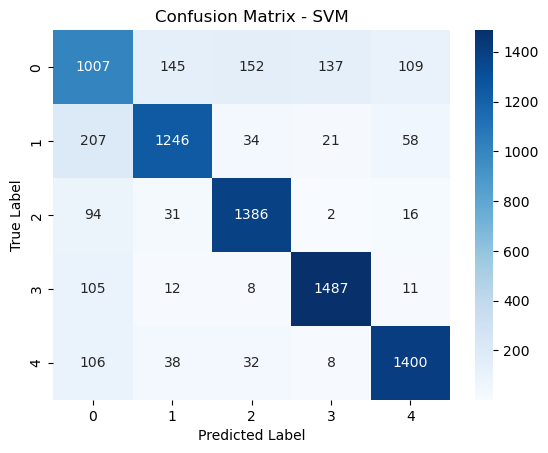

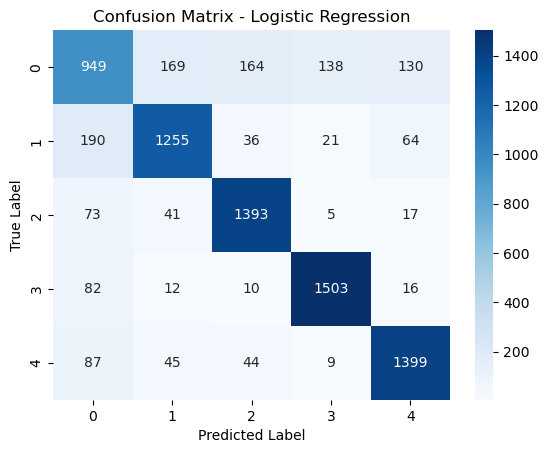

In [ ]:
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

# Matriz de confusión para SVM
plot_confusion_matrix(y_test, y_pred_svm, 'Confusion Matrix - SVM')

# Matriz de confusión para Regresión Logística
plot_confusion_matrix(y_test, logreg_predictions, 'Confusion Matrix - Logistic Regression')

## Random Forest con mejores Hiperparámetros + Cross Validation

Fitting 3 folds for each of 540 candidates, totalling 1620 fits
Cross-Validation Scores: [0.93026588 0.92453431 0.92087247 0.92692246 0.93025478]
Average Cross-Validation Score: 0.9265699810468737


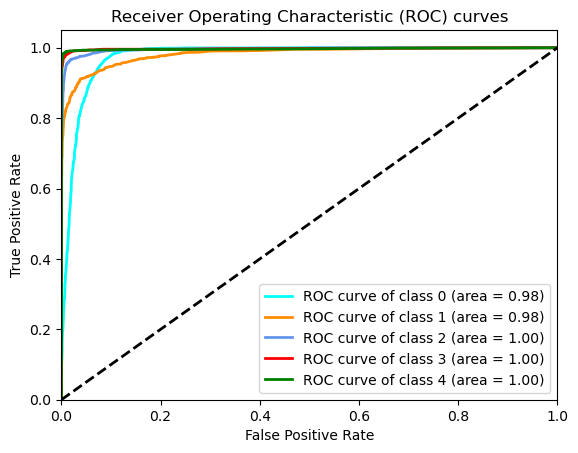

In [108]:
# Selección de características y variable objetivo
features = ['word_count','text_length', 'clean_tweet']
X = df_final[features]
y = df_final['cyberbullying_numeric_type']

# Dividir el conjunto de datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Pipeline de preprocesamiento
numeric_features = ['text_length','word_count']
text_features = 'clean_tweet'

# Transformadores
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

text_transformer = Pipeline(steps=[
    ('tfidf', TfidfVectorizer())
])

# Preprocesador de columnas
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('text', text_transformer, text_features)
    ])

# Definir el modelo Random Forest dentro de un Pipeline
rf = RandomForestClassifier(random_state=42)

pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', rf)])

# Definir los parámetros para la búsqueda de hiperparámetros
param_grid = {
    'classifier__max_features': [500, 1000, 2000, 'sqrt', 'log2'],
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_depth': [10, 20, 30, None],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4]
}

# Búsqueda de hiperparámetros con GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid=param_grid, cv=3, verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Mejor estimador encontrado por GridSearchCV
best_pipeline = grid_search.best_estimator_

# Validación cruzada
cv_scores = cross_val_score(best_pipeline, X_train, y_train, cv=5)
print("Cross-Validation Scores:", cv_scores)
print("Average Cross-Validation Score:", np.mean(cv_scores))

# Entrenar el modelo con los mejores hiperparámetros en todo el conjunto de entrenamiento
best_pipeline.fit(X_train, y_train)

# Predicciones
y_pred = best_pipeline.predict(X_test)

# Curvas ROC
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = len(cyberbullying_classes_final)

# Binarizar las etiquetas para ROC
y_test_bin = pd.get_dummies(y_test)
y_pred_prob = best_pipeline.predict_proba(X_test)

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin.iloc[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plotear las curvas ROC
plt.figure()
colors = ['aqua', 'darkorange', 'cornflowerblue', 'red', 'green']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) curves')
plt.legend(loc="lower right")
plt.show()

In [109]:
print("Mejores hiperparámetros encontrados por GridSearchCV:")
print(grid_search.best_params_)

Mejores hiperparámetros encontrados por GridSearchCV:
{'classifier__max_depth': None, 'classifier__max_features': 500, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 200}


Confusion Matrix:
 [[1394   65   59   22   10]
 [ 230 1317    7    4    8]
 [  57   14 1456    1    1]
 [  40    2    1 1580    0]
 [  16    4    5    5 1554]]
Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.90      0.85      1550
           1       0.94      0.84      0.89      1566
           2       0.95      0.95      0.95      1529
           3       0.98      0.97      0.98      1623
           4       0.99      0.98      0.98      1584

    accuracy                           0.93      7852
   macro avg       0.93      0.93      0.93      7852
weighted avg       0.93      0.93      0.93      7852



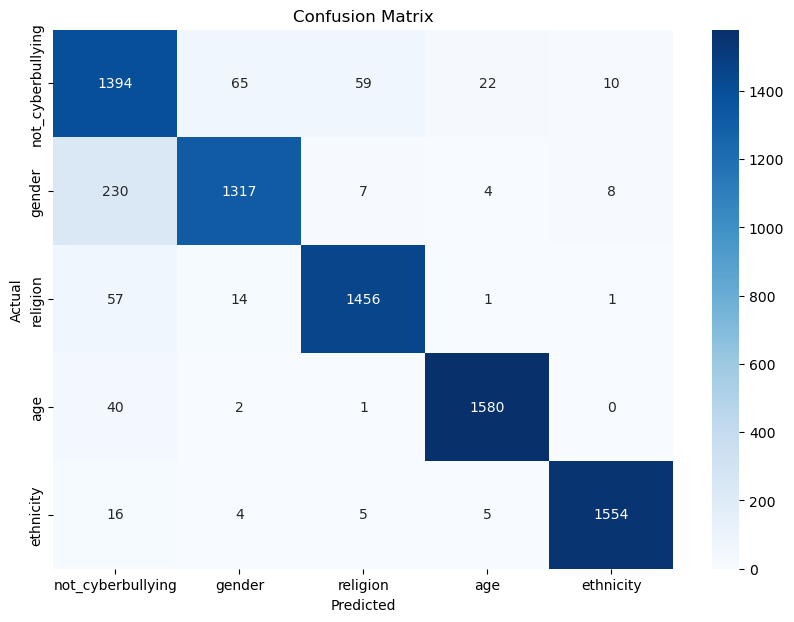

In [110]:
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=cyberbullying_classes_final, yticklabels=cyberbullying_classes_final)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# ENTRENAMIENTO

## Random Forest + Mejores Hiperparametros + TFIDF

In [37]:
import joblib

features = ['word_count', 'text_length', 'clean_tweet']
X = df_final[features]
y = df_final['cyberbullying_numeric_type']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Transformadores
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

text_transformer = Pipeline(steps=[
    ('tfidf', TfidfVectorizer())
])

# Preprocesador de columnas
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, ['text_length', 'word_count']),
        ('text', text_transformer, 'clean_tweet')
    ])

# Mejores hiperparámetros encontrados por GridSearchCV
best_params = {
    'classifier__max_depth': None,
    'classifier__max_features': 500,
    'classifier__min_samples_leaf': 1,
    'classifier__min_samples_split': 2,
    'classifier__n_estimators': 200
}

# Construcción del pipeline del modelo
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(
        max_depth=best_params['classifier__max_depth'],
        max_features=best_params['classifier__max_features'],
        min_samples_leaf=best_params['classifier__min_samples_leaf'],
        min_samples_split=best_params['classifier__min_samples_split'],
        n_estimators=best_params['classifier__n_estimators'],
        random_state=42))
])

# Validación cruzada
cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='accuracy')
print("Cross-validation scores:", cv_scores)
print("Mean cross-validation score:", cv_scores.mean())

# Entrenamiento del modelo
pipeline.fit(X_train, y_train)

# Predicciones en el conjunto de prueba
y_pred = pipeline.predict(X_test)


Cross-validation scores: [0.93010667 0.92485273 0.92055405 0.92676325 0.93025478]
Mean cross-validation score: 0.9265062969201423


#### Métricas de evaluación de Random Forest

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.90      0.85      1550
           1       0.94      0.84      0.89      1566
           2       0.95      0.95      0.95      1529
           3       0.98      0.97      0.98      1623
           4       0.99      0.98      0.98      1584

    accuracy                           0.93      7852
   macro avg       0.93      0.93      0.93      7852
weighted avg       0.93      0.93      0.93      7852

Confusion Matrix:


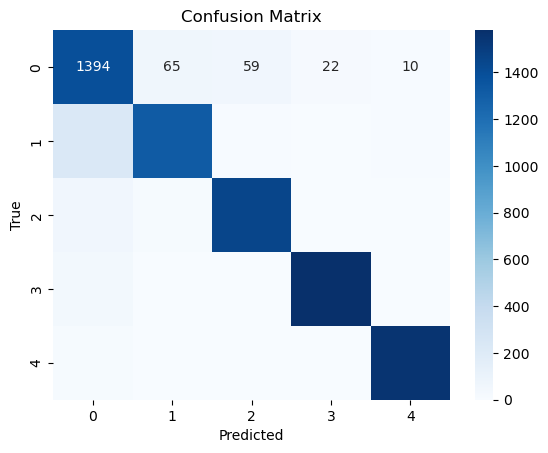

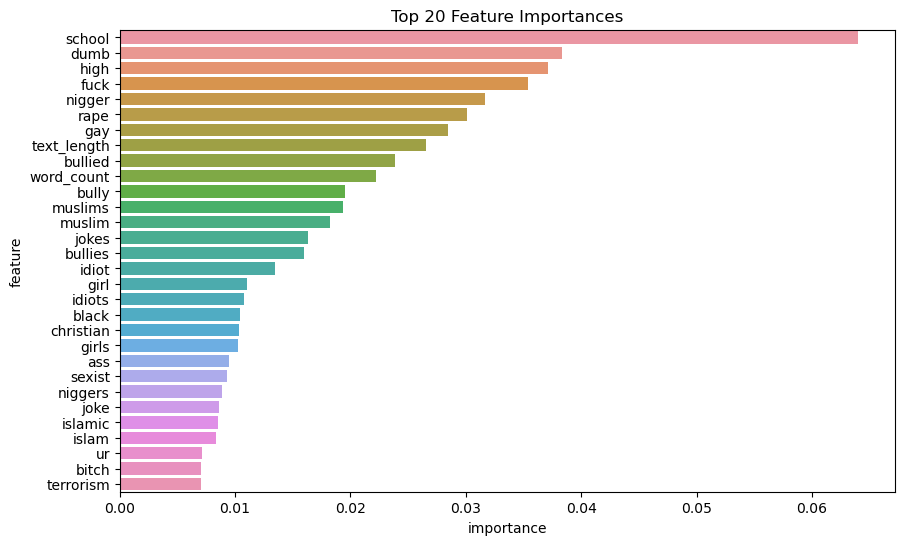

Modelo guardado como trained_random_forest_model.pkl


In [39]:
# Evaluación del modelo
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Matriz de confusión
print("Confusion Matrix:")
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Importancia de características
importances = pipeline.named_steps['classifier'].feature_importances_

# Obtener nombres de las características después del preprocesamiento
tfidf_feature_names = pipeline.named_steps['preprocessor'].named_transformers_['text'].named_steps['tfidf'].get_feature_names_out()
numeric_feature_names = ['text_length', 'word_count']
all_feature_names = list(numeric_feature_names) + list(tfidf_feature_names)


# Crear un DataFrame para las importancias de características
feature_importances = pd.DataFrame({'feature': all_feature_names, 'importance': importances})
feature_importances = feature_importances.sort_values(by='importance', ascending=False)

# Graficar las importancias de las características
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importances.head(30))
plt.title('Top 20 Feature Importances')
plt.show()

# Exportar el modelo entrenado
joblib_file = "trained_random_forest_model.pkl"
joblib.dump(pipeline, joblib_file)
print(f"Modelo guardado como {joblib_file}")


## DistilBert + Fine Tunning + GloVe embeddings

In [40]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('mps') if torch.backends.mps.is_available() else torch.device('cpu')
print("Running on:", device)

Running on: mps


In [41]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, confusion_matrix
import torch
from torch.utils.data import Dataset
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments, EarlyStoppingCallback
import matplotlib.pyplot as plt
import seaborn as sns


# Definir el tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# Dataset personalizado para Pytorch
class TweetDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# Supongamos que 'df_final' es el DataFrame que contiene los datos.
# Dividir los datos en conjuntos de entrenamiento y validación
train_df, val_df = train_test_split(df_final, test_size=0.2, random_state=42)

# Tokenizar los datos
train_encodings = tokenizer(train_df['clean_tweet'].tolist(), padding=True, truncation=True, return_tensors='pt')
val_encodings = tokenizer(val_df['clean_tweet'].tolist(), padding=True, truncation=True, return_tensors='pt')

train_dataset = TweetDataset(train_encodings, train_df['cyberbullying_numeric_type'].values)
val_dataset = TweetDataset(val_encodings, val_df['cyberbullying_numeric_type'].values)

# Inicializar el modelo
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=5)
model.to(device)

# Configuración del entrenamiento con early stopping
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=10,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy='epoch',  # Corregido
    save_strategy='epoch',        # Corregido
    save_total_limit=1,
    load_best_model_at_end=True,
    metric_for_best_model='eval_loss',
    greater_is_better=False,
    report_to="tensorboard"  # Para habilitar TensorBoard
)

# Métricas de evaluación
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'f1': f1,
    }

# Inicializar el entrenador con early stopping
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]  # Early stopping con paciencia de 3 épocas
)

# Entrenar el modelo
trainer.train()

# Evaluar el modelo
eval_result = trainer.evaluate()

# Obtener las predicciones
preds = trainer.predict(val_dataset)
labels_list = (val_df['cyberbullying_numeric_type'].values, preds.predictions.argmax(-1))

/opt/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/9820 [00:00<?, ?it/s]

{'loss': 1.6153, 'learning_rate': 1.0000000000000002e-06, 'epoch': 0.01}
{'loss': 1.61, 'learning_rate': 2.0000000000000003e-06, 'epoch': 0.02}
{'loss': 1.6096, 'learning_rate': 3e-06, 'epoch': 0.03}
{'loss': 1.5971, 'learning_rate': 4.000000000000001e-06, 'epoch': 0.04}
{'loss': 1.5798, 'learning_rate': 5e-06, 'epoch': 0.05}
{'loss': 1.5431, 'learning_rate': 6e-06, 'epoch': 0.06}
{'loss': 1.5063, 'learning_rate': 7.000000000000001e-06, 'epoch': 0.07}
{'loss': 1.4119, 'learning_rate': 8.000000000000001e-06, 'epoch': 0.08}
{'loss': 1.3217, 'learning_rate': 9e-06, 'epoch': 0.09}
{'loss': 1.1884, 'learning_rate': 1e-05, 'epoch': 0.1}
{'loss': 1.0238, 'learning_rate': 1.1000000000000001e-05, 'epoch': 0.11}
{'loss': 0.8952, 'learning_rate': 1.2e-05, 'epoch': 0.12}
{'loss': 0.7453, 'learning_rate': 1.3000000000000001e-05, 'epoch': 0.13}
{'loss': 0.6735, 'learning_rate': 1.4000000000000001e-05, 'epoch': 0.14}
{'loss': 0.563, 'learning_rate': 1.5e-05, 'epoch': 0.15}
{'loss': 0.4728, 'learning_

KeyboardInterrupt: 

#### Métricas de la evaluación de DistilBert

In [ ]:
# Mostrar los resultados de evaluación
print(f"Resultados de evaluación: {eval_result}")

# Calcular y mostrar la matriz de confusión
conf_matrix = confusion_matrix(labels_list[0], labels_list[1])
df_cm = pd.DataFrame(conf_matrix, index=[i for i in range(5)], columns=[i for i in range(5)])

plt.figure(figsize=(10, 7))
sns.heatmap(df_cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

Esto es lo que resultó la ejecución anterior: 

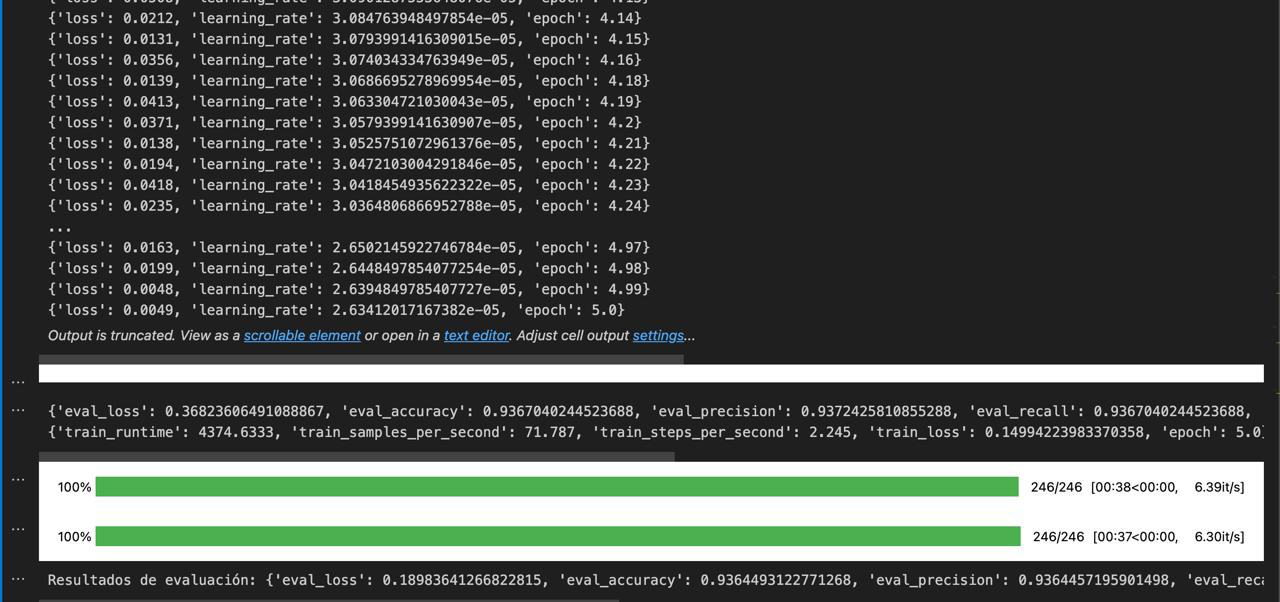
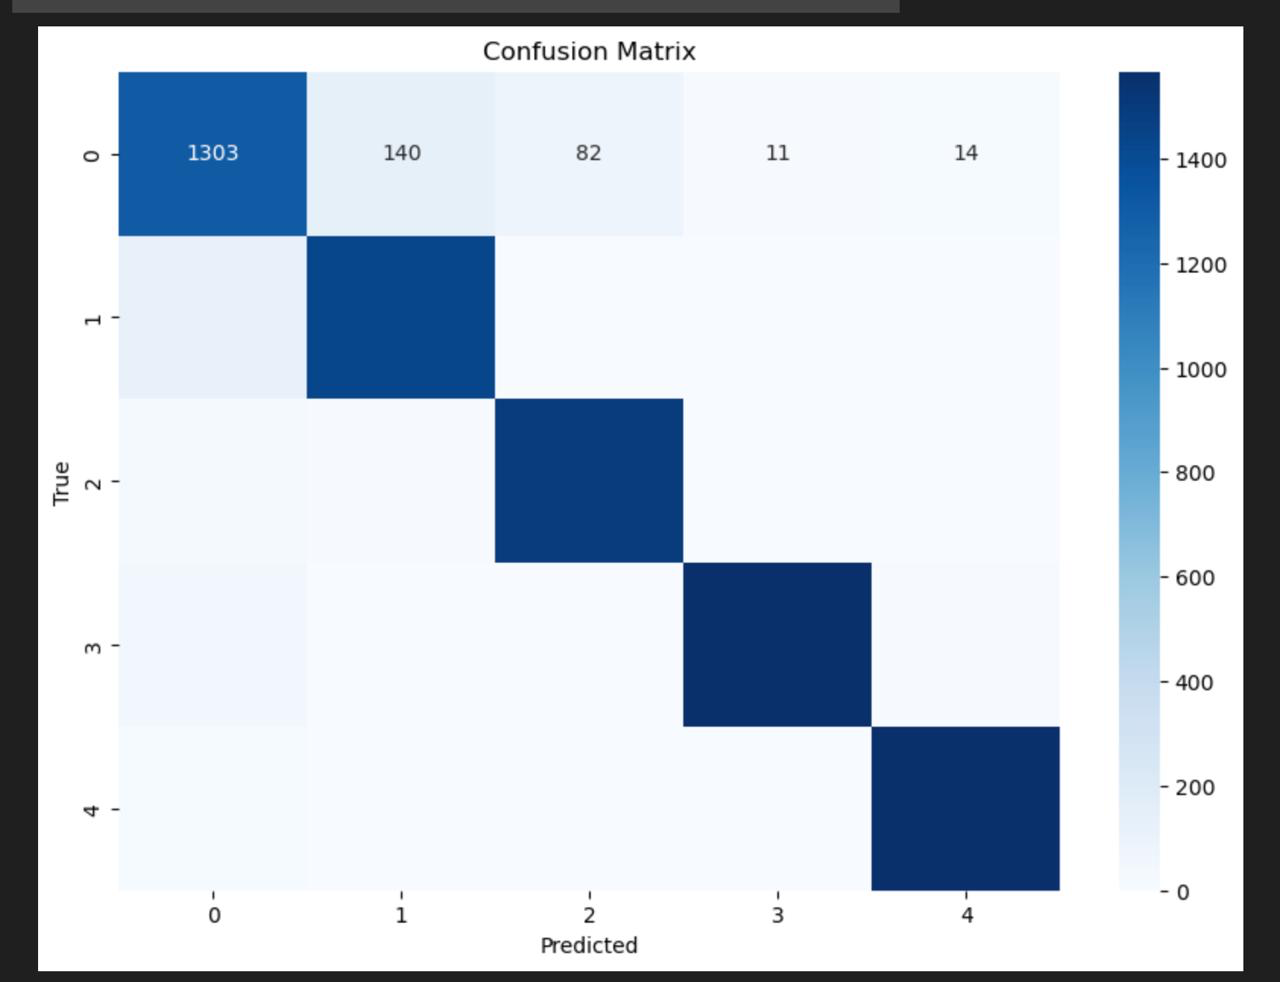